


---
<h1><B> Assignment 3 </h1></B></center>
<h4><B> Deep Learning </h4></B></center>
<h4><B> (AI5100) </h4></B></center>


---

<table>
<tr>
</tr>
<tr>
<td><h3> Name : </td>
<td><h3> Raj Popat </td>
</tr>
<tr>
<td><h3> Roll Number : </td>
<td> <h3>CS23MTECH14009 </td>
</tr>
<table>

---

# `Initialization stuff`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize
import math

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image data
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

print("Size of Training set is", len(trainset), "Size of testing set is", len(testset))

100%|██████████| 170498071/170498071 [00:02<00:00, 71617172.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Size of Training set is 50000 Size of testing set is 10000


In [4]:
def ShowImage(img,CLR_BAR = False,gray = False,title="Image", vmin=None, vmax=None):

  plt.figure()
  if vmin!=None and vmin<0:
    img = (img - vmin) / (vmax - vmin)
  if gray:
    plt.imshow(img,cmap='gray', vmin=vmin, vmax=vmax)
  else:
    plt.imshow(img, vmin=vmin, vmax=vmax)
  if CLR_BAR:
    plt.colorbar()
  plt.title(title)
  plt.show()

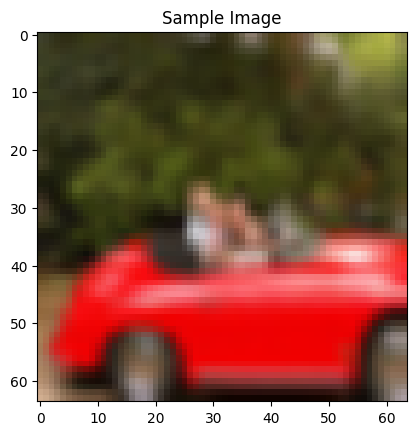

In [5]:
image = trainset[99][0]

# Convert the tensor to a NumPy array and transpose the dimensions to match the expected format (H, W, C)
resize = transforms.Resize((64, 64))
image = resize(image)
image = np.transpose(image.numpy(), (1, 2, 0))
image = (image + 1) / 2

ShowImage(image,title='Sample Image')

## Question

---

1. Implement a sample CNN with one or
more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to
implement the self-attention layer yourself and use it in the forward function defined by you. All
other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The
network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and
1x GAP). Please refer to the reading material provided here or any other similar one. [10 Marks]

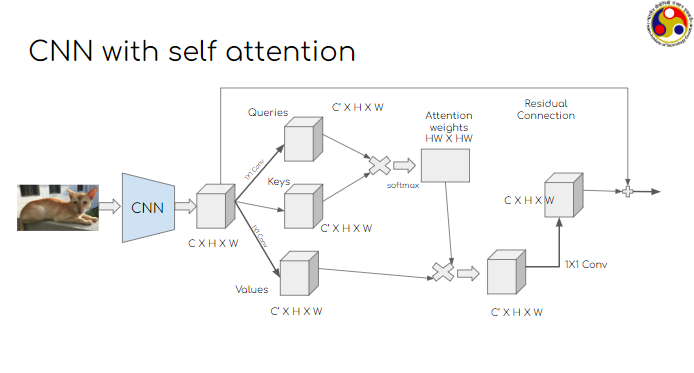


In [21]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()

        # defining query, key and value here i am taking same out_channels same as in_dim  not dividing in_dim//8 for complexity reduction
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, channels, -1).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, channels, -1)
        energy = torch.bmm(proj_query, proj_key) # calculating energy
        attention = F.softmax(energy, dim=-1) # calculating attention
        proj_value = self.value_conv(x).view(batch_size, channels, -1)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, width, height)
        out = self.gamma * out + x      #adding x to output
        return out

In [22]:
class CNNWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNWithSelfAttention, self).__init__()

        # Here I am using 5 convolution and self attension and 1 gap at last
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=3, padding=1)
        self.sa1 = SelfAttention(8)
        self.sa2 = SelfAttention(16)
        self.sa3 = SelfAttention(32)
        self.sa4 = SelfAttention(64)
        self.sa5 = SelfAttention(64)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.sa1(x)
        x = F.relu(self.conv2(x))
        x = self.sa2(x)
        x = F.relu(self.conv3(x))
        x = self.sa3(x)
        x = F.relu(self.conv4(x))
        x = self.sa4(x)
        x = F.relu(self.conv5(x))
        x = self.sa5(x)
        x = self.conv6(x)
        x = self.global_avg_pool(x)
        x = x.view(-1, 10)
        return x

In [23]:
# I am using DataLoaders
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

# here we check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the appropriate device
model = CNNWithSelfAttention().to(device)

# If multiple GPUs are available, parallelize the model
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)  # Adjust weight_decay as needed

# Training
num_epochs = 10
total_train_data = len(train_loader.dataset)
total_test_data = len(test_loader.dataset)

In [ ]:
# Lists to store accuracy values for plotting
train_accuracy = []
test_accuracy = []

In [ ]:
for epoch in range(num_epochs):
    # Training
    model.train()
    correct_train = 0
    total_train = 0

    # Wrap train_loader with tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update tqdm progress bar
            t.set_postfix(loss=loss.item(), accuracy=(correct_train / total_train) * 100)
            t.update()

    train_accuracy.append(100 * correct_train / total_train)

    # Testing
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy.append(100 * correct_test / total_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy[-1]:.2f}%, Test Accuracy: {test_accuracy[-1]:.2f}%')

Epoch 1/10: 100%|██████████| 1563/1563 [02:26<00:00, 10.65batch/s, accuracy=27.3, loss=1.65]


Epoch [1/10], Train Accuracy: 27.26%, Test Accuracy: 34.36%


Epoch 2/10: 100%|██████████| 1563/1563 [02:28<00:00, 10.51batch/s, accuracy=37.4, loss=1.81]


Epoch [2/10], Train Accuracy: 37.39%, Test Accuracy: 40.39%


Epoch 3/10: 100%|██████████| 1563/1563 [02:29<00:00, 10.42batch/s, accuracy=43.5, loss=1.56]


Epoch [3/10], Train Accuracy: 43.50%, Test Accuracy: 44.85%


Epoch 4/10: 100%|██████████| 1563/1563 [02:27<00:00, 10.57batch/s, accuracy=47.6, loss=1.63]


Epoch [4/10], Train Accuracy: 47.59%, Test Accuracy: 50.71%


Epoch 5/10: 100%|██████████| 1563/1563 [02:27<00:00, 10.62batch/s, accuracy=50.6, loss=1.19]


Epoch [5/10], Train Accuracy: 50.59%, Test Accuracy: 52.08%


Epoch 6/10: 100%|██████████| 1563/1563 [02:26<00:00, 10.68batch/s, accuracy=52.1, loss=1.18]


Epoch [6/10], Train Accuracy: 52.09%, Test Accuracy: 48.48%


Epoch 7/10: 100%|██████████| 1563/1563 [02:26<00:00, 10.69batch/s, accuracy=52.8, loss=1.27]


Epoch [7/10], Train Accuracy: 52.78%, Test Accuracy: 54.54%


Epoch 8/10: 100%|██████████| 1563/1563 [02:26<00:00, 10.70batch/s, accuracy=53.4, loss=1.4]


Epoch [8/10], Train Accuracy: 53.37%, Test Accuracy: 55.35%


Epoch 9/10: 100%|██████████| 1563/1563 [02:27<00:00, 10.58batch/s, accuracy=54, loss=1.23]


Epoch [9/10], Train Accuracy: 53.97%, Test Accuracy: 49.94%


Epoch 10/10: 100%|██████████| 1563/1563 [02:30<00:00, 10.39batch/s, accuracy=54.5, loss=1.11]


Epoch [10/10], Train Accuracy: 54.47%, Test Accuracy: 52.94%


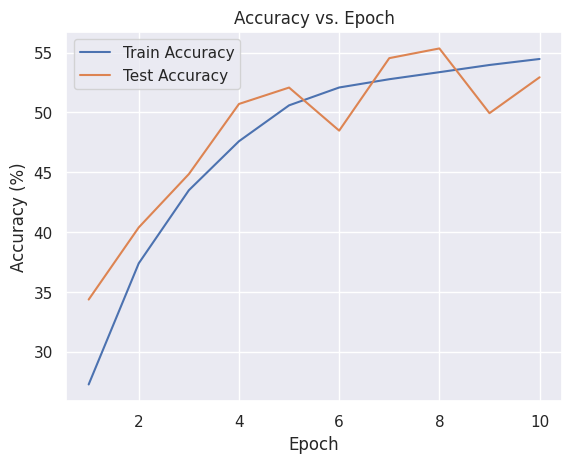

In [ ]:
# Plotting accuracy
import seaborn as sns
sns.set()
plt.plot(range(1, num_epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

## Question

---
2. Object Recognition with Vision Transformer: Implement and train an Encoder only Trans-
former (ViT-like) for the above object recognition task. In other words, implement multi-headed self-attention for the image classification (i.e., appending a < class > token to the image patches
that are accepted as input tokens). Compare the performance of the two implementations (try to
keep the number of parameters to be comparable and use the same amount of training and testing
data). [10 Marks]



In [6]:
# Define hyperparameters
image_size = 32                                               # CIFAR-10 image size
patch_size = 4                                                # Patch size for splitting the image
embed_dim = 64                                                # Embedding dimension
num_heads = 4                                                 # Number of heads for multi-headed self-attention
mlp_dim = 128                                                 # MLP dimension in encoder layer
num_layers = 4                                                # Number of encoder layers
num_classes = 10                                              # Number of classes in CIFAR-10
max_seq_len = 1 + (image_size // patch_size) ** 2             # Maximum sequence length including class token

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.patch_embedding = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embedding(x)   # Spliting the image into patches patch size here is 4
        x = x.flatten(start_dim=2)    # Flattening the patches
        x = x.transpose(1, 2)
        return x

In [8]:
# class for Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim

        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)              # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encodings to the input embeddings
        batch_size, seq_len, _ = x.size()
        x = x + self.pe[:, :seq_len, :]
        return x

In [9]:
# class for class token
class ClassToken(nn.Module):
    def __init__(self, embed_dim=768):
        super(ClassToken, self).__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x):
        B, N, _ = x.shape
        cls_tokens = self.cls_token.expand(B, 1, -1)
        # concatinating token and returning it
        x = torch.cat((cls_tokens, x), dim=1)
        return x

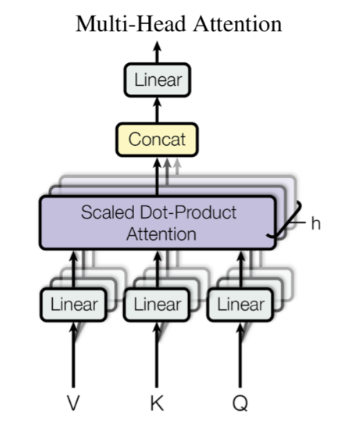

In [30]:
# Here defining Multi head Self Attension class were
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4):
        super(MultiheadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = math.sqrt(self.head_dim)

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, _ = x.shape

        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        query = query.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        key = key.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        value = value.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Calculate attention scores
        energy = torch.matmul(query, key.permute(0, 1, 3, 2)) / self.scale

        # Apply attention weights
        attention = F.softmax(energy, dim=-1)

        # Apply attention to the values
        x = torch.matmul(attention, value)

        x = x.permute(0, 2, 1, 3).contiguous().view(B, N, -1)

        x = self.fc_out(x)

        return x

In [31]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, mlp_dim=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadSelfAttention(embed_dim, num_heads)
        self.linear1 = nn.Linear(embed_dim, mlp_dim)
        self.linear2 = nn.Linear(mlp_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention
        x_res = x
        x = self.norm1(x + self.dropout(self.self_attn(x)))

        # MLP
        x_res = x
        x = self.norm2(x + self.dropout(self.linear2(F.relu(self.linear1(x)))))

        return x

In [32]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers=6, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(**kwargs) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [33]:
class ViT(nn.Module):
    def __init__(self, image_size=32, patch_size=16, embed_dim=768, num_heads=8, mlp_dim=2048, num_layers=6, num_classes=10):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)
        self.class_token = ClassToken(embed_dim=embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim=embed_dim, max_seq_len=(image_size // patch_size) ** 2 + 1)
        self.transformer_encoder = TransformerEncoder(num_layers=num_layers, embed_dim=embed_dim, num_heads=num_heads, mlp_dim=mlp_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.class_token(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)      # Global average pooling gap
        x = self.head(x)
        return x

In [34]:
# Initialize the model and move it to the appropriate device
model = ViT(image_size=image_size, patch_size=patch_size, embed_dim=embed_dim,num_heads=num_heads, mlp_dim=mlp_dim, num_layers=num_layers, num_classes=num_classes).to(device)

# Define optimizer and loss function we also can weigth decay here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Lists to store accuracy values for plotting
test_accuracy1 = []

In [36]:
# Train the model
def train(model, criterion, optimizer, train_loader):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [37]:
# Test the model
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [39]:
# Train and test loop
epochs = 10
for epoch in range(epochs):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_acc = test(model, test_loader)
    test_accuracy1.append(test_acc*100)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.4f} %')

Epoch: 1, Train Loss: 1.5001, Test Accuracy: 50.7600 %


Epoch: 2, Train Loss: 1.2796, Test Accuracy: 54.3900 %


Epoch: 3, Train Loss: 1.1763, Test Accuracy: 58.2300 %


Epoch: 4, Train Loss: 1.1063, Test Accuracy: 60.4100 %


Epoch: 5, Train Loss: 1.0493, Test Accuracy: 61.5500 %


Epoch: 6, Train Loss: 0.9985, Test Accuracy: 63.0000 %


Epoch: 7, Train Loss: 0.9637, Test Accuracy: 62.6200 %


Epoch: 8, Train Loss: 0.9243, Test Accuracy: 62.8300 %


Epoch: 9, Train Loss: 0.8929, Test Accuracy: 65.4900 %


Epoch: 10, Train Loss: 0.8674, Test Accuracy: 65.6300 %


In [ ]:
# Plotting accuracy
import seaborn as sns
num_epochs=10
sns.set()
plt.plot(range(1, num_epochs+1), test_accuracy, label='Test Accuracy of 1st question')
plt.plot(range(1, num_epochs+1), test_accuracy1, label='Test Accuracy of 2nd question')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

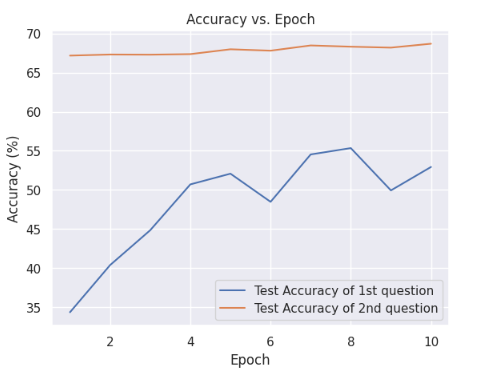

---
<center>
* Note: Please do Run All cells

---

<center><h1>

# Thank You!
# End
